# ***Tesla Stock Forecast ----> Using Tensorflow***

# 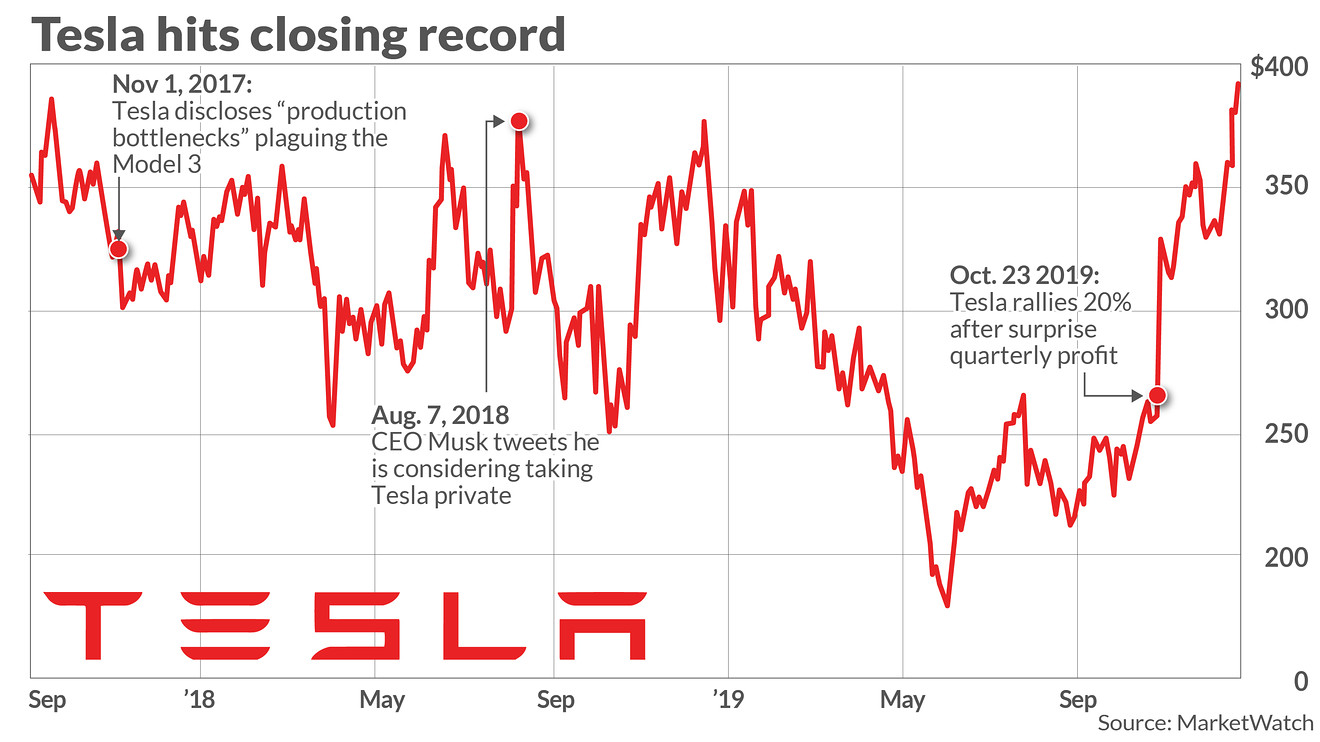

### ***Tesla is an American electric vehicle company whose aim is to accelerate the world’s transition towards sustainable energy. earlier this year the rise in the stock prices of Tesla made Elon Musk the richest person in the world. Predicting Stock prices is a great use case of machine learning both for financial and time series analysis. Tesla has been in the eyes of the world for a long time now as governments of so many countries all over the world are supporting the vision of Tesla***

***Importing the Libraries***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as ks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda, Input
from tensorflow.keras.models import Model
plt.style.use('default')
plt.style.use('ggplot')

***Loading the stock data***

In [ ]:
df = pd.read_csv('../input/tesla-stock-data-from-2010-to-2020/TSLA.csv')
print(df.shape)
df.head()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

***Lets visualize the entire stock prices of tesla over the past 10 year span***

In [ ]:
plt.figure(figsize=(10, 8), constrained_layout=True)
c = ['cyan', 'blue', 'green', 'red']
y = ['Close', 'Open', 'High', 'Low']
l = 2.0
for j, c in zip(y, c):
  plt.plot(df['Date'], df[j], color=c, linewidth=l, label=f'{j} stock')
  plt.title('Tesla Stock')
  plt.xlabel('Date')
  plt.ylabel('stock_value')
  plt.legend()
  l -=0.5

plt.show()

In [ ]:
df2 = df[['High', 'Low', 'Open', 'Close']]
df2.head()

***Preprocessing the data and spliting for model training and validation for stock price forecasting***

In [ ]:
def load_data(seq_len, series):
  x_data = []
  y_data = []

  for i in range(seq_len, len(series)):
    x = []
    y = []
    x.append([series['High'].iloc[i-seq_len: i].values])
    y.append(series['High'].iloc[i])
    x.append([series['Low'].iloc[i-seq_len: i].values])
    y.append(series['Low'].iloc[i])
    x.append([series['Open'].iloc[i-seq_len: i].values])
    y.append(series['Open'].iloc[i])
    x.append([series['Close'].iloc[i-seq_len: i].values])
    y.append(series['Close'].iloc[i])
    x_data.append(x)
    y_data.append(y)
  
  x_data_train = x_data[:int(0.9*(len(series)))]
  x_data_val = x_data[int(0.9*(len(series))):]
  
  
  y_data_train = y_data[:int(0.9*(len(series)))]
  y_data_val = y_data[int(0.9*(len(series))):]

  x_train = np.array(x_data_train)
  x_val = np.array(x_data_val)
  
  y_train = np.array(y_data_train)
  y_val = np.array(y_data_val)
  
  x_train = np.reshape(x_train, (x_train.shape[0], 4, seq_len))
  x_val = np.reshape(x_val, (x_val.shape[0], 4, seq_len))

  y_train = np.reshape(y_train, (y_train.shape[0], 1, 4))
  y_val = np.reshape(y_val, (y_val.shape[0], 1, 4))
  
  x_full = np.array(x_data)
  x_full = np.reshape(x_full, (x_full.shape[0], 4, seq_len))

  y_full = np.array(y_data)
  y_full = np.reshape(y_full, (y_full.shape[0], 1, 4))
  
  return (x_train, x_val, y_train, y_val, x_full, y_full)
  


In [ ]:
(x_train, x_val, y_train, y_val, x_full, y_full) = load_data(64, df2)

In [ ]:
print(f'the shape of all x_train is {x_train.shape}\n\
the shape of all y_train is {y_train.shape}\n\
the shape of all x_val is {x_val.shape}\n\
the shape of all y_val is {y_val.shape}')

In [ ]:
print(f'the shape of full x is {x_full.shape}\n\
the shape of full y is {y_full.shape}')

In [ ]:
def make_dataset(x, y, buffer_size=1000, batch_size=150):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.cache().shuffle(buffer_size).batch(batch_size)
    return data

In [ ]:
train_dataset = make_dataset(x_train, y_train)
val_dataset = make_dataset(x_val, y_val)

***Creating a custom model which produce multiple outputs for high, low , open and for closing stock Prices***

In [ ]:
def base_model(inputs):
  x = Conv1D(filters=128,kernel_size=4, activation='relu', name='conv_1D')(inputs)
  x = Bidirectional(LSTM(units=64, return_sequences=True, name='b_lstm_1'))(x)
  x = ks.layers.Dropout(0.2)(x)
  x = Bidirectional(LSTM(units=64, return_sequences=True, name='b_lstm_2'))(x)
  x = ks.layers.Dropout(0.2)(x)
  x = LSTM(units=32, return_sequences=True, name='lstm_3')(x)
  return x

def final_model(inputs):
  x = base_model(inputs)
  x = Dense(units=128, activation='relu', name='dense_1')(inputs)
  x = Dense(units=64, name='dense_2')(x)
  x = Lambda(lambda x:x*16, name='lambda_1')(x)
  high_stock = Dense(1, name='high_stock')(x)
  low_stock = Dense(1, name='low_stock')(x)
  open_stock = Dense(1, name='open_stock')(x)
  close_stock = Dense(1, name='close_stock')(x)
  
  model = Model(inputs=inputs, outputs=[high_stock, low_stock, open_stock, close_stock])
  return model

In [ ]:
inputs =Input(shape=(4, 64, ))
model = final_model(inputs)
model.summary()

In [ ]:
ks.utils.plot_model(model)

***Lets use a learning rate scheduler to pick up the best learning rate for the optimizer. we use Stochastic gradient descent as our optimizer and Huber loss function , set the metric as mean squared error***

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch /22))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss={
    'high_stock': ks.losses.Huber(), 
    'low_stock': ks.losses.Huber(),
    'open_stock': ks.losses.Huber(), 
    'close_stock': ks.losses.Huber() 
    },
     optimizer=optimizer,
     metrics={
         'high_stock': ['mae'], 
        'low_stock': ['mae'], 
        'open_stock': ['mae'],
        'close_stock': ['mae']
        })
history = model.fit(x=x_train, y=y_train, epochs=100, callbacks=[lr_schedule], verbose=0)


In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 1000])
plt.title('Loss w.r.t learning rate')
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.show()

***Now lets choose a best learning rate by visualizing the above plot and train our model again from scratch***

In [ ]:
model = final_model(inputs)
model.compile(loss={
    'high_stock': ks.losses.Huber(), 
    'low_stock': ks.losses.Huber(),
    'open_stock': ks.losses.Huber(), 
    'close_stock': ks.losses.Huber() 
    },
     optimizer=ks.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
     metrics={
         'high_stock': ['mae'], 
        'low_stock': ['mae'], 
        'open_stock': ['mae'],
        'close_stock': ['mae']
        })
history = model.fit(x_train, y_train, epochs=1300, verbose=0)

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.style.use('default')
plt.style.use('ggplot')
plt.figure(figsize=(9, 5))
#plt.plot(epochs[400:], mae, color='blue', label='trainig_mae')
plt.plot(epochs, loss, color='red', label='training_loss', linewidth=0.8)
plt.title('Training Loss')
plt.xlabel('epochs')
plt.xlim(0, 1000)
plt.ylim(0, 200)
plt.legend()
plt.show()

In [ ]:
high_stock_mae = history.history['high_stock_mae']
low_stock_mae = history.history['low_stock_mae']
open_stock_mae = history.history['open_stock_mae']
close_stock_mae = history.history['close_stock_mae']
epochs = range(len(high_stock_mae))
result = []
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
spec = gridspec.GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax = [ax1, ax2, ax3, ax4]
stock = [high_stock_mae, low_stock_mae, open_stock_mae, close_stock_mae]
title_stock = ['mae for high_stock', 'mae for low_stock', 'mae for open_stock', 'mae for close_stock']
color = ['red', 'blue', 'green', 'cyan']
for i in range(4):
  ax[i].plot(epochs, stock[i], color=color[i], alpha=0.8, linewidth=0.8)
  ax[i].set_ylim(0, 50)
  ax[i].set_title(title_stock[i])
  ax[i].set_xlabel('number of epochs')
  ax[i].set_ylabel('MAE')
  
plt.show()

***from the above few visuals it's proven that the model is performing good .So its time for the model to face and forecast some new data which it has'nt seen before***

In [ ]:
forecast = model.predict(x_val)
forecast = np.array(forecast)
forecast.shape

***the forecasted values are clustered in a nested list. the below function makes the task to seperate the stock values inorder to visualize***

In [ ]:
def sep_target(data):
  high_hat = []
  low_hat = []
  open_hat = []
  close_hat = []
  for zeroth in data[0, :, :]:
    high_hat.append(zeroth[0][0])
    low_hat.append(zeroth[1][0])
    open_hat.append(zeroth[2][0])
    close_hat.append(zeroth[3][0])
  high_hat = np.array(high_hat)
  low_hat = np.array(low_hat)
  open_hat = np.array(open_hat)
  close_hat = np.array(close_hat)
  return (high_hat, low_hat, open_hat, close_hat)

In [ ]:
high_preds, low_preds, open_preds, close_preds = sep_target(forecast)

***the target real values are alos clustered in a nested list. the below function makes the task to seperate the stock values inorder to visualize***

In [ ]:
def sep_ans(data):
  high_hat = []
  low_hat = []
  open_hat = []
  close_hat = []
  for zeroth in data[:, 0]:
    high_hat.append(zeroth[0])
    low_hat.append(zeroth[1])
    open_hat.append(zeroth[2])
    close_hat.append(zeroth[3])
  high_hat = np.array(high_hat)
  low_hat = np.array(low_hat)
  open_hat = np.array(open_hat)
  close_hat = np.array(close_hat)
  return (high_hat, low_hat, open_hat, close_hat)

In [ ]:
high_real, low_real, open_real, close_real = sep_ans(y_val)

In [ ]:
def plt_forecast(x, y, title):
  plt.style.use('fivethirtyeight')
  plt.figure(figsize=(30, 10))
  plt.plot(x, color='red', linewidth=1.2, label='predicted value')
  plt.plot(y, color='blue', linewidth=0.9, label='true value')
  plt.title(title, fontsize=40)
  plt.legend(fontsize=30)
  
  plt.show()

In [ ]:
plt_forecast(high_preds, high_real, 'High stock forecast')

In [ ]:
plt_forecast(low_preds, low_real, 'Low stock forecast')

In [ ]:
plt_forecast(open_preds, open_real, 'opening stock forecast')

In [ ]:
plt_forecast(close_preds, close_real, 'Closing stock forecast')

***from the above plots the forecast was close to the real price. Thus the model evaluated and the models forecast is great.***

In [ ]:
forecast_val = pd.DataFrame({
    'open': open_preds, 'close': close_preds, 'high': high_preds, 'low': low_preds
})

In [ ]:
forecast_val.head(10)

In [ ]:
full_forecast = model.predict(x_full)
full_forecast = np.array(full_forecast)
full_forecast.shape

In [ ]:
high_preds, low_preds, open_preds, close_preds = sep_target(full_forecast)

In [ ]:
high_real, low_real, open_real, close_real = sep_ans(y_full)

In [ ]:
plt_forecast(high_preds, high_real, 'Full Forecast for High Stock Value')

In [ ]:
plt_forecast(low_preds, low_real, 'Full Forecast for Low Stock Value')

In [ ]:
plt_forecast(open_preds, open_real, 'Full Forecast for opening Stock Value')

In [ ]:
plt_forecast(close_preds, close_real, 'Full Forecast for closing Stock Value')